In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from pandas import DataFrame
from datetime import datetime
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D ,AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
#from tensorflow.keras.optimizers import Adam
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# input file path
datasetdir = "D://indivdual_models//Dataset//2022_MC9K_single_drug"
resultdir = "D://indivdual_models//Result//Model_generation//2022_MC9K_single_drug"

C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorf

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2588478539175311232
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8267490918
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3842454999780074581
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [2]:
drug_list = ["AEW541","Nilotinib","17-AAG","PHA-665752","Lapatinib","Nutlin-3"
            ,"AZD0530","PF2341066","L-685458","ZD-6474","Panobinostat","Sorafenib"
            ,"Irinotecan","Topotecan","LBW242","PD-0325901","PD-0332991","Paclitaxel"
            ,"PLX4720","RAF265","TAE684","TKI258","Erlotinib","AZD6244"]

In [3]:
# hyperparameters of CNN
num_classes = 1
learning_rate = 0.0002
training_epochs = 40
batch_size = 50
# img_rows, img_cols = 154, 154


In [4]:
#reset Keras Session for GPU memory refreshing
def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

Starttime: 20221007
AEW541_//n
train_X shape: (303, 21213)
303 train samples
75 test samples
train_X shape: (303, 21213, 1)
303 train samples
75 test samples
StartTime : 2022-10-07 16:02:40.584351

EndTime : 2022-10-07 16:02:43.049634
StartTime : 2022-10-07 16:02:43.049634

Train on 303 samples, validate on 75 samples
Epoch 1/40
303/303 [==============================] - 7s 25ms/step - loss: 5.7633 - mse: 5.7633 - mae: 2.1243 - val_loss: 2.9166 - val_mse: 2.9166 - val_mae: 1.5773
Epoch 2/40
303/303 [==============================] - 1s 2ms/step - loss: 5.1670 - mse: 5.1670 - mae: 2.0002 - val_loss: 2.9121 - val_mse: 2.9121 - val_mae: 1.5762
Epoch 3/40
303/303 [==============================] - 1s 2ms/step - loss: 4.2094 - mse: 4.2094 - mae: 1.8571 - val_loss: 2.9480 - val_mse: 2.9480 - val_mae: 1.5854
Epoch 4/40
303/303 [==============================] - 1s 2ms/step - loss: 3.9086 - mse: 3.9086 - mae: 1.7985 - val_loss: 2.9447 - val_mse: 2.9447 - val_mae: 1.5846
Epoch 5/40
303/303 [===

Epoch 4/40
248/248 [==============================] - 0s 2ms/step - loss: 2.2272 - mse: 2.2272 - mae: 1.2657 - val_loss: 3.3434 - val_mse: 3.3434 - val_mae: 1.7554
Epoch 5/40
248/248 [==============================] - 0s 2ms/step - loss: 1.8311 - mse: 1.8311 - mae: 1.1865 - val_loss: 3.1485 - val_mse: 3.1485 - val_mae: 1.6970
Epoch 6/40
248/248 [==============================] - 0s 2ms/step - loss: 1.4618 - mse: 1.4618 - mae: 1.0767 - val_loss: 3.0333 - val_mse: 3.0333 - val_mae: 1.6613
Epoch 7/40
248/248 [==============================] - 0s 2ms/step - loss: 1.2865 - mse: 1.2865 - mae: 0.9567 - val_loss: 2.7381 - val_mse: 2.7381 - val_mae: 1.5650
Epoch 8/40
248/248 [==============================] - 0s 2ms/step - loss: 1.0475 - mse: 1.0475 - mae: 0.8753 - val_loss: 2.4220 - val_mse: 2.4220 - val_mae: 1.4533
Epoch 9/40
248/248 [==============================] - 0s 2ms/step - loss: 1.0366 - mse: 1.0366 - mae: 0.8457 - val_loss: 2.1823 - val_mse: 2.1823 - val_mae: 1.3628
Epoch 10/40
248/

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001F8F288D518>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 302 samples, validate on 75 samples
Epoch 1/40
302/302 [==============================] - 6s 20ms/step - loss: 5.2294 - mse: 5.2294 - mae: 1.9187 - val_loss: 5.1739 - val_mse: 5.1739 - val_mae: 2.0163
Epoch 2/40
302/302 [==============================] - 1s 2ms/step - loss: 3.8167 - mse: 3.8167 - mae: 1.6494 - val_loss: 4.9744 - val_mse: 4.9744 - val_mae: 1.9730
Epoch 3/40
302/302 [==============================] - 1s 2ms/step - loss: 3.2833 - mse: 3.2833 - mae: 1.5085 - val_loss: 4.9071 - val_mse: 4.9071 - val_mae: 1.9584
Epoch 4/40
302/302 [==============================] - 1s 2ms/step - loss: 2.8087 - mse: 2.8087 - mae: 1.3962 - val_loss: 5.0602 - val_mse: 5.0602 - val_mae: 1.9919
Epoch 5/40
302/302 [==============================] - 1s 2ms/step - loss: 2.5025 - mse: 2.5025 - mae: 1.3241 - val_loss: 5.1566 - val_mse: 5.1566 - val_mae: 2.0126
Epoch 6/40
302/302 [==============================] - 1s 2ms/step - loss: 2.0358 - mse: 2.0358 - mae: 1.2075 - val_loss: 5.3225 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA35036400>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 302 samples, validate on 75 samples
Epoch 1/40
302/302 [==============================] - 6s 20ms/step - loss: 4.1669 - mse: 4.1669 - mae: 1.8592 - val_loss: 3.8735 - val_mse: 3.8735 - val_mae: 1.9369
Epoch 2/40
302/302 [==============================] - 1s 2ms/step - loss: 4.0311 - mse: 4.0311 - mae: 1.7886 - val_loss: 3.8877 - val_mse: 3.8877 - val_mae: 1.9406
Epoch 3/40
302/302 [==============================] - 1s 2ms/step - loss: 3.0563 - mse: 3.0563 - mae: 1.5883 - val_loss: 3.7275 - val_mse: 3.7275 - val_mae: 1.8992
Epoch 4/40
302/302 [==============================] - 1s 2ms/step - loss: 2.7075 - mse: 2.7075 - mae: 1.4845 - val_loss: 3.6813 - val_mse: 3.6813 - val_mae: 1.8873
Epoch 5/40
302/302 [==============================] - 1s 2ms/step - loss: 2.5115 - mse: 2.5115 - mae: 1.4419 - val_loss: 3.1907 - val_mse: 3.1907 - val_mae: 1.7560
Epoch 6/40
302/302 [==============================] - 1s 2ms/step - loss: 1.9821 - mse: 1.9821 - mae: 1.2606 - val_loss: 2.8978 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA47D7F630>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 303 samples, validate on 75 samples
Epoch 1/40
303/303 [==============================] - 6s 20ms/step - loss: 4.9648 - mse: 4.9648 - mae: 2.0567 - val_loss: 3.5876 - val_mse: 3.5876 - val_mae: 1.8163
Epoch 2/40
303/303 [==============================] - 1s 2ms/step - loss: 4.0573 - mse: 4.0573 - mae: 1.8381 - val_loss: 3.3767 - val_mse: 3.3767 - val_mae: 1.7620
Epoch 3/40
303/303 [==============================] - 1s 2ms/step - loss: 3.4931 - mse: 3.4931 - mae: 1.7093 - val_loss: 3.3140 - val_mse: 3.3140 - val_mae: 1.7457
Epoch 4/40
303/303 [==============================] - 1s 2ms/step - loss: 3.2586 - mse: 3.2586 - mae: 1.6518 - val_loss: 3.3018 - val_mse: 3.3018 - val_mae: 1.7425
Epoch 5/40
303/303 [==============================] - 1s 2ms/step - loss: 2.9815 - mse: 2.9815 - mae: 1.5829 - val_loss: 3.0993 - val_mse: 3.0993 - val_mae: 1.6884
Epoch 6/40
303/303 [==============================] - 1s 2ms/step - loss: 2.7074 - mse: 2.7074 - mae: 1.4765 - val_loss: 3.3342 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001F9A45FE780>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 303 samples, validate on 75 samples
Epoch 1/40
303/303 [==============================] - 6s 20ms/step - loss: 6.4209 - mse: 6.4209 - mae: 2.4067 - val_loss: 4.5652 - val_mse: 4.5652 - val_mae: 2.0992
Epoch 2/40
303/303 [==============================] - 1s 2ms/step - loss: 6.1448 - mse: 6.1448 - mae: 2.3232 - val_loss: 4.4386 - val_mse: 4.4386 - val_mae: 2.0676
Epoch 3/40
303/303 [==============================] - 1s 2ms/step - loss: 5.1655 - mse: 5.1655 - mae: 2.1414 - val_loss: 4.2817 - val_mse: 4.2817 - val_mae: 2.0276
Epoch 4/40
303/303 [==============================] - 1s 2ms/step - loss: 4.8413 - mse: 4.8413 - mae: 2.0832 - val_loss: 4.0911 - val_mse: 4.0911 - val_mae: 1.9778
Epoch 5/40
303/303 [==============================] - 1s 2ms/step - loss: 4.2481 - mse: 4.2481 - mae: 1.9472 - val_loss: 3.7446 - val_mse: 3.7446 - val_mae: 1.8837
Epoch 6/40
303/303 [==============================] - 1s 2ms/step - loss: 3.9226 - mse: 3.9226 - mae: 1.8759 - val_loss: 3.4839 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA45658F60>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 303 samples, validate on 75 samples
Epoch 1/40
303/303 [==============================] - 6s 20ms/step - loss: 5.4452 - mse: 5.4452 - mae: 2.1425 - val_loss: 3.3518 - val_mse: 3.3518 - val_mae: 1.7299
Epoch 2/40
303/303 [==============================] - 1s 2ms/step - loss: 4.8285 - mse: 4.8285 - mae: 1.9895 - val_loss: 3.2310 - val_mse: 3.2310 - val_mae: 1.6979
Epoch 3/40
303/303 [==============================] - 1s 2ms/step - loss: 3.8947 - mse: 3.8947 - mae: 1.8186 - val_loss: 3.0940 - val_mse: 3.0940 - val_mae: 1.6607
Epoch 4/40
303/303 [==============================] - 1s 2ms/step - loss: 3.6006 - mse: 3.6006 - mae: 1.7464 - val_loss: 3.0403 - val_mse: 3.0403 - val_mae: 1.6460
Epoch 5/40
303/303 [==============================] - 1s 2ms/step - loss: 3.3146 - mse: 3.3146 - mae: 1.6567 - val_loss: 2.9575 - val_mse: 2.9575 - val_mae: 1.6234
Epoch 6/40
303/303 [==============================] - 1s 2ms/step - loss: 3.0833 - mse: 3.0833 - mae: 1.5878 - val_loss: 2.9858 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001F8EB27A5C0>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


EndTime : 2022-10-07 16:08:39.125276
StartTime : 2022-10-07 16:08:39.125276
Train on 303 samples, validate on 75 samples
Epoch 1/40
303/303 [==============================] - 6s 20ms/step - loss: 4.7482 - mse: 4.7482 - mae: 1.9913 - val_loss: 3.1376 - val_mse: 3.1376 - val_mae: 1.6989
Epoch 2/40
303/303 [==============================] - 1s 2ms/step - loss: 4.1326 - mse: 4.1326 - mae: 1.8463 - val_loss: 3.0659 - val_mse: 3.0659 - val_mae: 1.6798
Epoch 3/40
303/303 [==============================] - 1s 2ms/step - loss: 3.5709 - mse: 3.5709 - mae: 1.6898 - val_loss: 2.9112 - val_mse: 2.9112 - val_mae: 1.6376
Epoch 4/40
303/303 [==============================] - 1s 2ms/step - loss: 3.1464 - mse: 3.1464 - mae: 1.6012 - val_loss: 2.6554 - val_mse: 2.6554 - val_mae: 1.5649
Epoch 5/40
303/303 [==============================] - 1s 2ms/step - loss: 2.9626 - mse: 2.9626 - mae: 1.5628 - val_loss: 2.7636 - val_mse: 2.7636 - val_mae: 1.5961
Epoch 6/40
303/303 [==============================] - 1s 2

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA432C6400>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 292 samples, validate on 73 samples
Epoch 1/40
292/292 [==============================] - 6s 21ms/step - loss: 7.5664 - mse: 7.5664 - mae: 2.6133 - val_loss: 4.1469 - val_mse: 4.1469 - val_mae: 2.0213
Epoch 2/40
292/292 [==============================] - 0s 2ms/step - loss: 6.4825 - mse: 6.4825 - mae: 2.4013 - val_loss: 4.1389 - val_mse: 4.1389 - val_mae: 2.0193
Epoch 3/40
292/292 [==============================] - 0s 2ms/step - loss: 5.8987 - mse: 5.8987 - mae: 2.3091 - val_loss: 3.9842 - val_mse: 3.9842 - val_mae: 1.9813
Epoch 4/40
292/292 [==============================] - 0s 2ms/step - loss: 5.2169 - mse: 5.2169 - mae: 2.1664 - val_loss: 3.9200 - val_mse: 3.9200 - val_mae: 1.9653
Epoch 5/40
292/292 [==============================] - 0s 2ms/step - loss: 4.6933 - mse: 4.6933 - mae: 2.0639 - val_loss: 3.9042 - val_mse: 3.9042 - val_mae: 1.9613
Epoch 6/40
292/292 [==============================] - 0s 2ms/step - loss: 4.1894 - mse: 4.1894 - mae: 1.9089 - val_loss: 3.6068 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA440E6F60>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


EndTime : 2022-10-07 16:10:20.752044
StartTime : 2022-10-07 16:10:20.752044
Train on 298 samples, validate on 74 samples
Epoch 1/40
298/298 [==============================] - 6s 20ms/step - loss: 3.8797 - mse: 3.8797 - mae: 1.7658 - val_loss: 3.3163 - val_mse: 3.3163 - val_mae: 1.7193
Epoch 2/40
298/298 [==============================] - 0s 2ms/step - loss: 3.2641 - mse: 3.2641 - mae: 1.6288 - val_loss: 3.1576 - val_mse: 3.1576 - val_mae: 1.6773
Epoch 3/40
298/298 [==============================] - 0s 2ms/step - loss: 3.0035 - mse: 3.0035 - mae: 1.5633 - val_loss: 2.9050 - val_mse: 2.9050 - val_mae: 1.6093
Epoch 4/40
298/298 [==============================] - 0s 2ms/step - loss: 2.4389 - mse: 2.4389 - mae: 1.3898 - val_loss: 2.6168 - val_mse: 2.6168 - val_mae: 1.5272
Epoch 5/40
298/298 [==============================] - 0s 2ms/step - loss: 2.0827 - mse: 2.0827 - mae: 1.2955 - val_loss: 2.4417 - val_mse: 2.4417 - val_mae: 1.4742
Epoch 6/40
298/298 [==============================] - 0s 2

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA4D698128>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 300 samples, validate on 75 samples
Epoch 1/40
300/300 [==============================] - 6s 20ms/step - loss: 9.5177 - mse: 9.5177 - mae: 2.8333 - val_loss: 8.1249 - val_mse: 8.1249 - val_mae: 2.7318
Epoch 2/40
300/300 [==============================] - 0s 2ms/step - loss: 8.6366 - mse: 8.6366 - mae: 2.7188 - val_loss: 7.9183 - val_mse: 7.9183 - val_mae: 2.6947
Epoch 3/40
300/300 [==============================] - 0s 2ms/step - loss: 7.7966 - mse: 7.7966 - mae: 2.6074 - val_loss: 7.4468 - val_mse: 7.4468 - val_mae: 2.6081
Epoch 4/40
300/300 [==============================] - 0s 2ms/step - loss: 6.8281 - mse: 6.8281 - mae: 2.4697 - val_loss: 7.0344 - val_mse: 7.0344 - val_mae: 2.5295
Epoch 5/40
300/300 [==============================] - 0s 2ms/step - loss: 6.4662 - mse: 6.4662 - mae: 2.3819 - val_loss: 6.6436 - val_mse: 6.6436 - val_mae: 2.4528
Epoch 6/40
300/300 [==============================] - 0s 2ms/step - loss: 5.6171 - mse: 5.6171 - mae: 2.2160 - val_loss: 6.6982 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA36737C50>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 302 samples, validate on 75 samples
Epoch 1/40
302/302 [==============================] - 6s 20ms/step - loss: 5.6429 - mse: 5.6429 - mae: 2.2173 - val_loss: 3.7340 - val_mse: 3.7340 - val_mae: 1.8978
Epoch 2/40
302/302 [==============================] - 1s 2ms/step - loss: 5.2663 - mse: 5.2663 - mae: 2.0819 - val_loss: 3.7772 - val_mse: 3.7772 - val_mae: 1.9089
Epoch 3/40
302/302 [==============================] - 1s 2ms/step - loss: 4.5151 - mse: 4.5151 - mae: 1.9746 - val_loss: 3.7263 - val_mse: 3.7263 - val_mae: 1.8958
Epoch 4/40
302/302 [==============================] - 1s 2ms/step - loss: 3.8164 - mse: 3.8164 - mae: 1.8025 - val_loss: 3.5640 - val_mse: 3.5640 - val_mae: 1.8535
Epoch 5/40
302/302 [==============================] - 1s 2ms/step - loss: 3.4025 - mse: 3.4025 - mae: 1.7154 - val_loss: 3.2282 - val_mse: 3.2282 - val_mae: 1.7626
Epoch 6/40
302/302 [==============================] - 1s 2ms/step - loss: 3.3220 - mse: 3.3220 - mae: 1.6183 - val_loss: 2.7524 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA400EE588>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 183 samples, validate on 45 samples
Epoch 1/40
183/183 [==============================] - 6s 32ms/step - loss: 4.3937 - mse: 4.3937 - mae: 1.6913 - val_loss: 3.1615 - val_mse: 3.1615 - val_mae: 1.5156
Epoch 2/40
183/183 [==============================] - 0s 2ms/step - loss: 3.0905 - mse: 3.0905 - mae: 1.4305 - val_loss: 3.0743 - val_mse: 3.0743 - val_mae: 1.4916
Epoch 3/40
183/183 [==============================] - 0s 2ms/step - loss: 2.8902 - mse: 2.8902 - mae: 1.3260 - val_loss: 2.9986 - val_mse: 2.9986 - val_mae: 1.4705
Epoch 4/40
183/183 [==============================] - 0s 2ms/step - loss: 2.6354 - mse: 2.6354 - mae: 1.2435 - val_loss: 2.9232 - val_mse: 2.9232 - val_mae: 1.4498
Epoch 5/40
183/183 [==============================] - 0s 2ms/step - loss: 2.4558 - mse: 2.4558 - mae: 1.3020 - val_loss: 2.8621 - val_mse: 2.8621 - val_mae: 1.4325
Epoch 6/40
183/183 [==============================] - 0s 2ms/step - loss: 1.7658 - mse: 1.7658 - mae: 1.1083 - val_loss: 2.7390 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA459222E8>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 303 samples, validate on 75 samples
Epoch 1/40
303/303 [==============================] - 6s 20ms/step - loss: 4.8533 - mse: 4.8533 - mae: 1.8023 - val_loss: 2.6936 - val_mse: 2.6936 - val_mae: 1.3421
Epoch 2/40
303/303 [==============================] - 1s 2ms/step - loss: 3.4671 - mse: 3.4671 - mae: 1.5269 - val_loss: 2.7582 - val_mse: 2.7582 - val_mae: 1.3589
Epoch 3/40
303/303 [==============================] - 1s 2ms/step - loss: 2.9497 - mse: 2.9497 - mae: 1.4059 - val_loss: 2.7073 - val_mse: 2.7073 - val_mae: 1.3458
Epoch 4/40
303/303 [==============================] - 1s 2ms/step - loss: 2.9506 - mse: 2.9506 - mae: 1.3999 - val_loss: 2.6575 - val_mse: 2.6575 - val_mae: 1.3320
Epoch 5/40
303/303 [==============================] - 1s 2ms/step - loss: 2.6668 - mse: 2.6668 - mae: 1.3613 - val_loss: 2.7136 - val_mse: 2.7136 - val_mae: 1.3474
Epoch 6/40
303/303 [==============================] - 1s 2ms/step - loss: 2.7760 - mse: 2.7760 - mae: 1.3442 - val_loss: 2.8029 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA461B8080>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 302 samples, validate on 75 samples
Epoch 1/40
302/302 [==============================] - 6s 21ms/step - loss: 4.6898 - mse: 4.6898 - mae: 1.9970 - val_loss: 4.1770 - val_mse: 4.1770 - val_mae: 2.0247
Epoch 2/40
302/302 [==============================] - 1s 2ms/step - loss: 4.0038 - mse: 4.0038 - mae: 1.8148 - val_loss: 4.3736 - val_mse: 4.3736 - val_mae: 2.0711
Epoch 3/40
302/302 [==============================] - 1s 2ms/step - loss: 3.4565 - mse: 3.4565 - mae: 1.6862 - val_loss: 4.3743 - val_mse: 4.3743 - val_mae: 2.0713
Epoch 4/40
302/302 [==============================] - 1s 2ms/step - loss: 3.1044 - mse: 3.1044 - mae: 1.6125 - val_loss: 4.0185 - val_mse: 4.0185 - val_mae: 1.9864
Epoch 5/40
302/302 [==============================] - 1s 2ms/step - loss: 2.5621 - mse: 2.5621 - mae: 1.4693 - val_loss: 3.6377 - val_mse: 3.6377 - val_mae: 1.8903
Epoch 6/40
302/302 [==============================] - 1s 2ms/step - loss: 2.5161 - mse: 2.5161 - mae: 1.4224 - val_loss: 3.6606 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001F8EBD0D240>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 303 samples, validate on 75 samples
Epoch 1/40
303/303 [==============================] - 6s 20ms/step - loss: 6.8527 - mse: 6.8527 - mae: 2.3535 - val_loss: 5.0600 - val_mse: 5.0600 - val_mae: 1.9816
Epoch 2/40
303/303 [==============================] - 1s 2ms/step - loss: 4.6084 - mse: 4.6084 - mae: 1.8781 - val_loss: 5.0189 - val_mse: 5.0189 - val_mae: 1.9607
Epoch 3/40
303/303 [==============================] - 1s 2ms/step - loss: 4.1371 - mse: 4.1371 - mae: 1.7995 - val_loss: 4.9850 - val_mse: 4.9850 - val_mae: 1.9410
Epoch 4/40
303/303 [==============================] - 1s 2ms/step - loss: 3.8665 - mse: 3.8665 - mae: 1.7415 - val_loss: 4.9947 - val_mse: 4.9947 - val_mae: 1.9470
Epoch 5/40
303/303 [==============================] - 1s 2ms/step - loss: 3.4528 - mse: 3.4528 - mae: 1.5855 - val_loss: 5.0285 - val_mse: 5.0285 - val_mae: 1.9661
Epoch 6/40
303/303 [==============================] - 1s 2ms/step - loss: 3.4253 - mse: 3.4253 - mae: 1.5825 - val_loss: 4.9878 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA345DB7B8>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 258 samples, validate on 64 samples
Epoch 1/40
258/258 [==============================] - 6s 23ms/step - loss: 4.4511 - mse: 4.4511 - mae: 1.9302 - val_loss: 3.9752 - val_mse: 3.9752 - val_mae: 1.9486
Epoch 2/40
258/258 [==============================] - 0s 2ms/step - loss: 4.0015 - mse: 4.0015 - mae: 1.8129 - val_loss: 4.0515 - val_mse: 4.0515 - val_mae: 1.9677
Epoch 3/40
258/258 [==============================] - 0s 2ms/step - loss: 3.5796 - mse: 3.5796 - mae: 1.7290 - val_loss: 3.9987 - val_mse: 3.9987 - val_mae: 1.9545
Epoch 4/40
258/258 [==============================] - 0s 2ms/step - loss: 3.2003 - mse: 3.2003 - mae: 1.5904 - val_loss: 3.8728 - val_mse: 3.8728 - val_mae: 1.9226
Epoch 5/40
258/258 [==============================] - 0s 2ms/step - loss: 2.8153 - mse: 2.8153 - mae: 1.5231 - val_loss: 3.9552 - val_mse: 3.9552 - val_mae: 1.9435
Epoch 6/40
258/258 [==============================] - 0s 2ms/step - loss: 2.6050 - mse: 2.6050 - mae: 1.4680 - val_loss: 3.9927 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA354884E0>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 302 samples, validate on 75 samples
Epoch 1/40
302/302 [==============================] - 6s 20ms/step - loss: 26.1939 - mse: 26.1939 - mae: 4.7919 - val_loss: 23.0078 - val_mse: 23.0078 - val_mae: 4.6484
Epoch 2/40
302/302 [==============================] - 1s 2ms/step - loss: 23.5083 - mse: 23.5083 - mae: 4.5929 - val_loss: 22.4593 - val_mse: 22.4593 - val_mae: 4.5937
Epoch 3/40
302/302 [==============================] - 1s 2ms/step - loss: 22.2538 - mse: 22.2538 - mae: 4.4270 - val_loss: 22.4996 - val_mse: 22.4996 - val_mae: 4.5978
Epoch 4/40
302/302 [==============================] - 1s 2ms/step - loss: 20.5562 - mse: 20.5562 - mae: 4.2976 - val_loss: 22.2155 - val_mse: 22.2155 - val_mae: 4.5691
Epoch 5/40
302/302 [==============================] - 1s 2ms/step - loss: 19.4656 - mse: 19.4655 - mae: 4.1559 - val_loss: 21.4328 - val_mse: 21.4328 - val_mae: 4.4888
Epoch 6/40
302/302 [==============================] - 1s 2ms/step - loss: 17.9789 - mse: 17.9789 - mae: 3.9851 - v

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA3262A160>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


EndTime : 2022-10-07 16:17:46.848405
StartTime : 2022-10-07 16:17:46.848405
Train on 298 samples, validate on 74 samples
Epoch 1/40
298/298 [==============================] - 6s 20ms/step - loss: 4.4856 - mse: 4.4856 - mae: 1.9664 - val_loss: 4.1374 - val_mse: 4.1374 - val_mae: 2.0221
Epoch 2/40
298/298 [==============================] - 0s 2ms/step - loss: 4.2355 - mse: 4.2355 - mae: 1.8760 - val_loss: 3.9619 - val_mse: 3.9619 - val_mae: 1.9791
Epoch 3/40
298/298 [==============================] - 0s 2ms/step - loss: 3.3471 - mse: 3.3471 - mae: 1.6871 - val_loss: 3.8462 - val_mse: 3.8462 - val_mae: 1.9502
Epoch 4/40
298/298 [==============================] - 0s 2ms/step - loss: 3.2358 - mse: 3.2358 - mae: 1.6433 - val_loss: 3.6330 - val_mse: 3.6330 - val_mae: 1.8957
Epoch 5/40
298/298 [==============================] - 0s 2ms/step - loss: 2.8538 - mse: 2.8538 - mae: 1.5619 - val_loss: 3.1263 - val_mse: 3.1263 - val_mae: 1.7592
Epoch 6/40
298/298 [==============================] - 0s 2

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA36716860>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 274 samples, validate on 68 samples
Epoch 1/40
274/274 [==============================] - 6s 21ms/step - loss: 2.3129 - mse: 2.3129 - mae: 1.2456 - val_loss: 1.8719 - val_mse: 1.8719 - val_mae: 1.1810
Epoch 2/40
274/274 [==============================] - 0s 2ms/step - loss: 1.5165 - mse: 1.5165 - mae: 0.9936 - val_loss: 1.9030 - val_mse: 1.9030 - val_mae: 1.1919
Epoch 3/40
274/274 [==============================] - 0s 2ms/step - loss: 1.0414 - mse: 1.0414 - mae: 0.8048 - val_loss: 1.8354 - val_mse: 1.8354 - val_mae: 1.1678
Epoch 4/40
274/274 [==============================] - 0s 2ms/step - loss: 1.0094 - mse: 1.0094 - mae: 0.8014 - val_loss: 1.8718 - val_mse: 1.8718 - val_mae: 1.1813
Epoch 5/40
274/274 [==============================] - 0s 2ms/step - loss: 0.8353 - mse: 0.8353 - mae: 0.7104 - val_loss: 1.8489 - val_mse: 1.8489 - val_mae: 1.1731
Epoch 6/40
274/274 [==============================] - 0s 2ms/step - loss: 0.6427 - mse: 0.6427 - mae: 0.6206 - val_loss: 1.8358 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA328695C0>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


EndTime : 2022-10-07 16:19:22.577307
StartTime : 2022-10-07 16:19:22.577307
Train on 303 samples, validate on 75 samples
Epoch 1/40
303/303 [==============================] - 6s 20ms/step - loss: 1.7619 - mse: 1.7619 - mae: 1.0655 - val_loss: 2.2184 - val_mse: 2.2184 - val_mae: 1.3362
Epoch 2/40
303/303 [==============================] - 1s 2ms/step - loss: 1.5294 - mse: 1.5294 - mae: 0.9592 - val_loss: 2.1384 - val_mse: 2.1384 - val_mae: 1.3095
Epoch 3/40
303/303 [==============================] - 1s 2ms/step - loss: 1.1876 - mse: 1.1876 - mae: 0.8681 - val_loss: 2.1207 - val_mse: 2.1207 - val_mae: 1.3033
Epoch 4/40
303/303 [==============================] - 1s 2ms/step - loss: 1.0588 - mse: 1.0588 - mae: 0.8271 - val_loss: 2.0502 - val_mse: 2.0502 - val_mae: 1.2792
Epoch 5/40
303/303 [==============================] - 1s 2ms/step - loss: 0.9963 - mse: 0.9963 - mae: 0.7922 - val_loss: 1.9841 - val_mse: 1.9841 - val_mae: 1.2558
Epoch 6/40
303/303 [==============================] - 1s 2

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA425E0DA0>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 303 samples, validate on 75 samples
Epoch 1/40
303/303 [==============================] - 6s 20ms/step - loss: 3.4482 - mse: 3.4482 - mae: 1.6468 - val_loss: 2.9515 - val_mse: 2.9515 - val_mae: 1.6326
Epoch 2/40
303/303 [==============================] - 1s 2ms/step - loss: 2.7389 - mse: 2.7389 - mae: 1.4869 - val_loss: 2.9325 - val_mse: 2.9325 - val_mae: 1.6267
Epoch 3/40
303/303 [==============================] - 1s 2ms/step - loss: 2.5012 - mse: 2.5012 - mae: 1.4040 - val_loss: 2.7835 - val_mse: 2.7835 - val_mae: 1.5810
Epoch 4/40
303/303 [==============================] - 1s 2ms/step - loss: 2.1305 - mse: 2.1305 - mae: 1.2947 - val_loss: 2.5958 - val_mse: 2.5958 - val_mae: 1.5215
Epoch 5/40
303/303 [==============================] - 1s 2ms/step - loss: 1.9275 - mse: 1.9275 - mae: 1.2286 - val_loss: 2.4101 - val_mse: 2.4101 - val_mae: 1.4601
Epoch 6/40
303/303 [==============================] - 1s 2ms/step - loss: 1.7488 - mse: 1.7488 - mae: 1.1492 - val_loss: 2.3601 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA43E50908>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 303 samples, validate on 75 samples
Epoch 1/40
303/303 [==============================] - 6s 20ms/step - loss: 3.8601 - mse: 3.8601 - mae: 1.7834 - val_loss: 3.8043 - val_mse: 3.8043 - val_mae: 1.8857
Epoch 2/40
303/303 [==============================] - 1s 2ms/step - loss: 3.4670 - mse: 3.4670 - mae: 1.6412 - val_loss: 3.7866 - val_mse: 3.7866 - val_mae: 1.8815
Epoch 3/40
303/303 [==============================] - 1s 2ms/step - loss: 3.0259 - mse: 3.0259 - mae: 1.5726 - val_loss: 3.8359 - val_mse: 3.8359 - val_mae: 1.8934
Epoch 4/40
303/303 [==============================] - 1s 2ms/step - loss: 2.7701 - mse: 2.7701 - mae: 1.4946 - val_loss: 3.8849 - val_mse: 3.8849 - val_mae: 1.9053
Epoch 5/40
303/303 [==============================] - 1s 2ms/step - loss: 2.3277 - mse: 2.3277 - mae: 1.3626 - val_loss: 3.8297 - val_mse: 3.8297 - val_mae: 1.8919
Epoch 6/40
303/303 [==============================] - 1s 2ms/step - loss: 2.0495 - mse: 2.0495 - mae: 1.2969 - val_loss: 3.3394 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001FA46B8EB70>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


EndTime : 2022-10-07 16:21:54.686537
StartTime : 2022-10-07 16:21:54.686537
Train on 302 samples, validate on 75 samples
Epoch 1/40
302/302 [==============================] - 6s 20ms/step - loss: 6.0905 - mse: 6.0905 - mae: 2.2078 - val_loss: 4.0328 - val_mse: 4.0328 - val_mae: 1.8700
Epoch 2/40
302/302 [==============================] - 1s 2ms/step - loss: 4.6615 - mse: 4.6615 - mae: 1.9479 - val_loss: 3.9334 - val_mse: 3.9334 - val_mae: 1.8421
Epoch 3/40
302/302 [==============================] - 1s 2ms/step - loss: 3.8191 - mse: 3.8191 - mae: 1.7362 - val_loss: 3.9189 - val_mse: 3.9189 - val_mae: 1.8378
Epoch 4/40
302/302 [==============================] - 1s 2ms/step - loss: 3.8157 - mse: 3.8157 - mae: 1.7187 - val_loss: 3.9015 - val_mse: 3.9015 - val_mae: 1.8328
Epoch 5/40
302/302 [==============================] - 1s 2ms/step - loss: 3.1346 - mse: 3.1346 - mae: 1.5432 - val_loss: 3.6401 - val_mse: 3.6401 - val_mae: 1.7532
Epoch 6/40
302/302 [==============================] - 1s 2

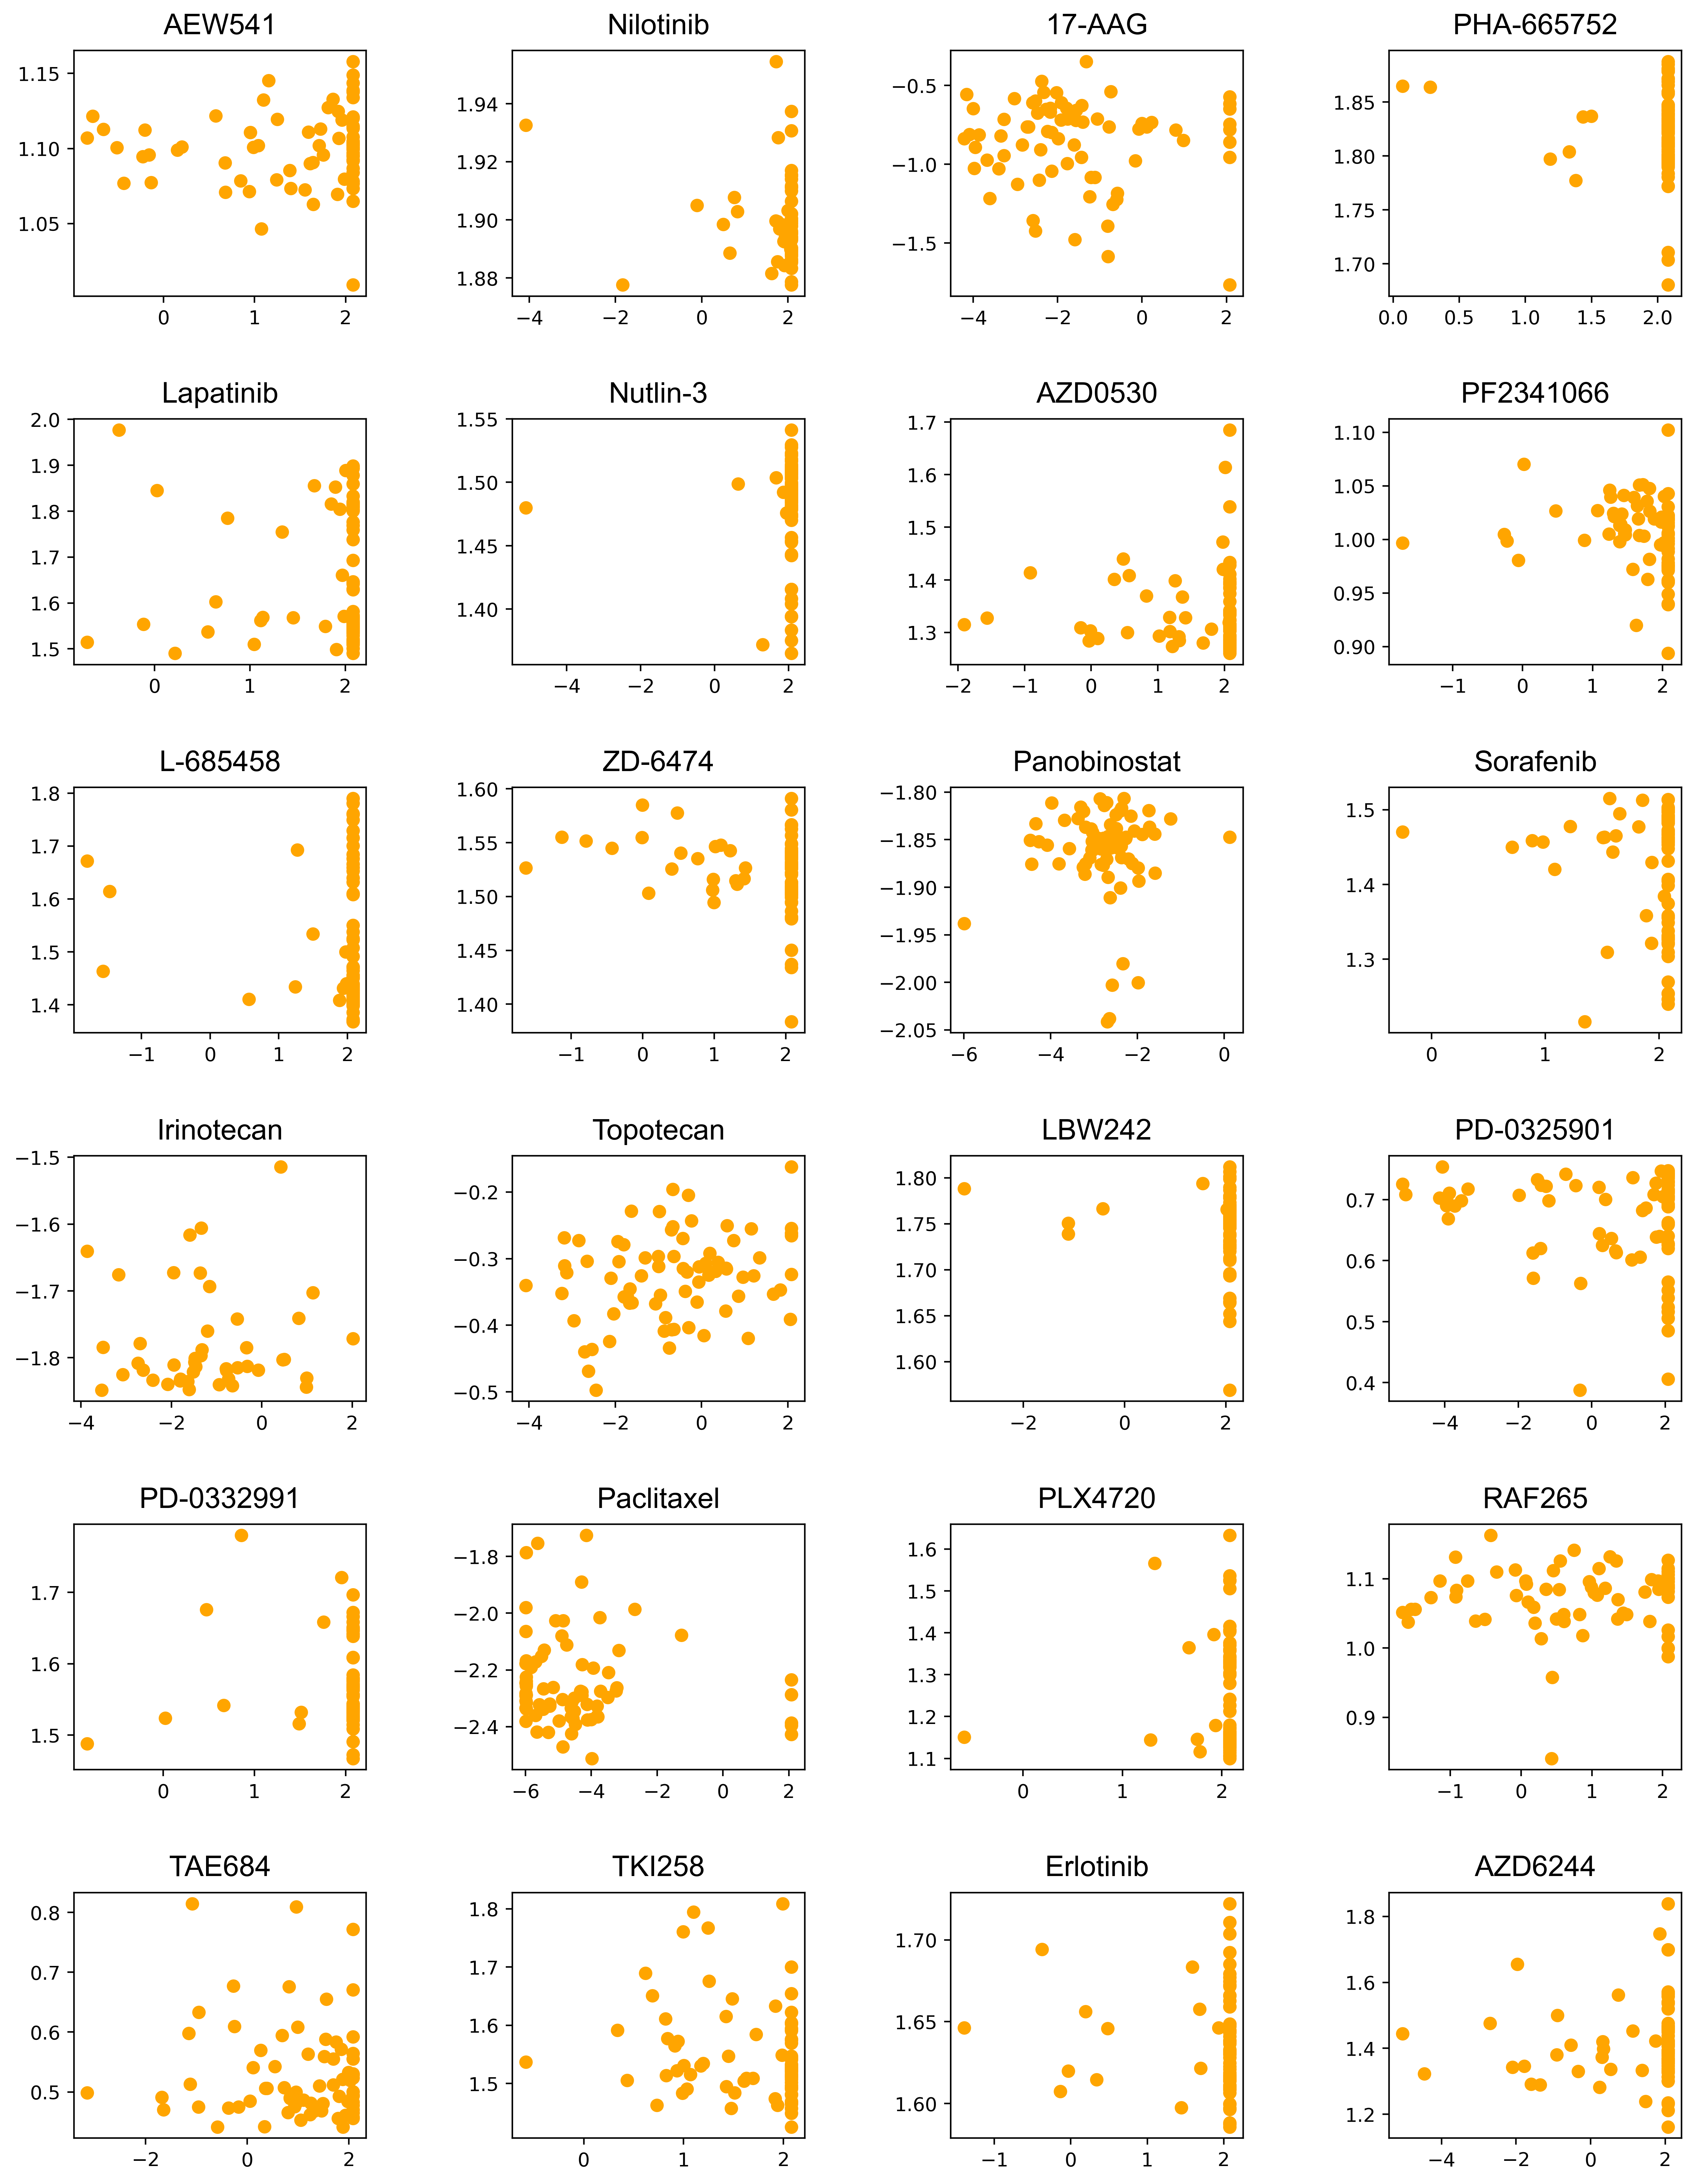

In [5]:
from datetime import datetime
now = datetime.now()
day = now.strftime("%Y%m%d")
print("Starttime: " + day)

rmselist = []
r2list = []

# drug_list = ["Topotecan"]
fig = plt.figure(figsize=(15,20),dpi=400)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
num = 1
for dname in drug_list:
    
    print('%s_//n' % dname)
    # read input file and index file for training and test set
    dataset = np.load(datasetdir + "//MC9K_%s.npz" % dname)
    ss0 = np.load(datasetdir + '//MC9K_%s_0_8_2.npz' % dname)

    # input and index file assign
    x = dataset['x']
    y = dataset['y']
    # y_linear = dataset['y_lnIC50']
    ss0_train = ss0['train']
    ss0_test = ss0['test']
    
    # training and test dataset assign
    train_X, train_y = x[ss0_train], y[ss0_train]
    test_X, test_y = x[ss0_test], y[ss0_test]

    # data typing and the number of dataset
    train_X = train_X.astype('float32')
    test_X = test_X.astype('float32')
    # train_X /= 255
    # test_X /= 255
    print('train_X shape:', train_X.shape)
    print(train_X.shape[0], 'train samples')
    print(test_X.shape[0], 'test samples')
    
    # data reshape for CNN
    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1],1)
    test_X = test_X.reshape(test_X.shape[0], test_X.shape[1],1)
    
    # data typing and the number of dataset
    train_X = train_X.astype('float32')
    test_X = test_X.astype('float32')
    # train_X /= 255
    # test_X /= 255
    print('train_X shape:', train_X.shape)
    print(train_X.shape[0], 'train samples')
    print(test_X.shape[0], 'test samples')
    
    # model architecture
    StartTime8 = datetime.now()
    print("StartTime :", StartTime8)

    # In[10]:
    with tf.device('/GPU:0'):
        inputs = Input(shape=(train_X.shape[1],1),name='inputs')

        x = Conv1D(16, kernel_size=3, strides=2, padding="same")(inputs)
        x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
    #     y = x
        x = Activation('tanh')(x)

        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)


        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)


        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)


        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=2, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
    #     x = BatchNormalization()(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)


        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=2, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
    #     x = BatchNormalization()(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)


        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

    #     x = AveragePooling1D(pool_size=8)(x)
        x = Flatten()(x)
        x = Dense(units=2048, name='dense1'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout1') (x)
        x = Activation('relu')(x)

    #    x = Reshape((300,1))(x)

    #    x = Conv1D(30, kernel_size=150, strides=1, activation = 'relu')(x)
    #    x = MaxPooling1D(pool_size=2)(x)
    #    x = BatchNormalization()(x)

        x = Dense(units=1024, name='dense5'  ) (x)
        x = BatchNormalization()(x)
        y = x
        x = Dropout(0.1, name='dropout5') (x)
        x = Activation('relu')(x)

        x = Dense(units=512, name='dense6'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout6') (x)
        x = Activation('relu')(x)

        x = Dense(units=1024, name='dense7'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout7') (x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Dense(units=512, name='dense8'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout8') (x)
        x = Activation('relu')(x)

        x = Dense(units=256, name='dense9'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout9') (x)
        x = Activation('relu')(x)

        x = Dense(units=128, name='dense10'  ) (x)
        x = BatchNormalization()(x)
        y = x
        x = Dropout(0.1, name='dropout10') (x)
        x = Activation('relu')(x)


        predictions = Dense(1, activation='linear', name='predictions', kernel_initializer='he_normal')(x)
    #     predictions = Dense(1, activation='linear', name='predictions')(x)



        model = Model(inputs=inputs, outputs=predictions, name='Test_v2_DNN20190327')
        model.compile(loss=keras.losses.mean_squared_error,
                      optimizer=keras.optimizers.Adam(learning_rate),
                      metrics=['mse','mae'])
        EndTime8 = datetime.now()
        print("EndTime :", EndTime8)
    
    
    # model fitting
    StartTime8 = datetime.now()
    print("StartTime :", StartTime8)
    with tf.device('/GPU:0'):
        model_train = model.fit(train_X, train_y, batch_size=batch_size,epochs=training_epochs,verbose=1,
                            validation_data=(test_X, test_y))

    EndTime8 = datetime.now()
    print("EndTime :", EndTime8)
    
    import json
    from keras.models import model_from_json, load_model

    # Option 1: Save Weights + Architecture
    model.save_weights(resultdir+ '//ResNet//MC9K_ResNet_%s.h5' % dname)
    with open(resultdir + '//ResNet//MC9K_ResNet_%s.json' % dname, 'w') as f:
        f.write(model.to_json())
    
    
    predicted_classes = model.predict(test_X)
    predicted_value = predicted_classes
    # saving predicted ln(IC50)s and ln(IC50)s in the test set
    a = pd.DataFrame(predicted_value)
    b = pd.DataFrame(test_y)
    c = pd.concat([a,b], axis=1)
    c.columns=["Predicted","Test"]
    c.to_csv(resultdir + '//ResNet//predicted_table//MC9K_ResNet_%s_pred_and_val_result.csv' % dname, index=False)

    # RMSE
    rse = ((b[0]-a[0])**2).sum()
    mse = rse / len(b)
    rmse = np.sqrt(mse)
    print("%s’s final rmse value is = %f" % (dname,rmse))
    
    # R-squared value
    r2_value = r2_score(b,a)
    print("%s R-squared value is = %f" % (dname,r2_value))
    rmselist.append(rmse)
    r2list.append(r2_value)
          
          
    plt.subplot(6,4,num)
    plt.scatter(test_y,predicted_value,c='orange')
    plt.title(dname,fontdict ={'fontsize' : 15},fontname="Arial",y = 1.02)
    plt.tick_params(labelsize=10)
    
    
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

    # out of memory
    import tensorflow as tf
    with tf.Graph().as_default():
        gpu_options = tf.GPUOptions(allow_growth=True)

    
    num += 1
#     plt.scatter(test_y,predicted_value,c='red')
#     plt.xlabel('test_IC50_value')
#     plt.ylabel('predicted_IC50_value')
#     plt.savefig(workdir + '//%s_test_scatterplot.png' % dname)
    reset_keras()

figdir = "D://indivdual_models//Result//Figure"
plt.savefig(figdir +'//MC9K_single_drug_ResNet_plot.png', dpi=400)

In [6]:
a = pd.DataFrame(drug_list)
b = pd.DataFrame(rmselist)
c =pd.DataFrame(r2list)
result = pd.concat([a,b,c],axis=1)
result.columns = ['Drug','RMSE','R2value']

In [7]:
result

,Drug,RMSE,R2value
0,AEW541,0.925117,-0.167209
1,Nilotinib,1.004718,-0.035481
2,17-AAG,1.879961,-0.206984
3,PHA-665752,0.389309,-0.243796
4,Lapatinib,0.668662,-0.103717
5,Nutlin-3,0.962160,-0.303351
6,AZD0530,0.919094,-0.095966
7,PF2341066,0.944491,-0.938609
8,L-685458,0.856727,-0.290007
9,ZD-6474,0.869629,-0.036430


In [8]:
result.to_csv(resultdir +'//MC9K_ResNet_24drugs_metrics.csv', index=False)